Last session introduced the basics of PyTorch. Now, let's use that knowledge and train our first neural net. We will use the same (FashionMNIST) dataset we started with last time. For simplicity, let us just copy that code.  

Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw
Processing...
Done!


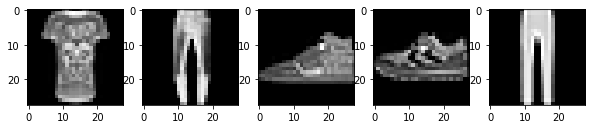

In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=16, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=16, shuffle=False)
images, labels = iter(trainDataLoader).next()
plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.imshow(images[index].squeeze().numpy(),cmap=plt.cm.gray)

OK, done. The only thing we really need to change is the architecture of the neural net (PyTorch handles all the autodiff calculations under the hood.) Let us define a simple 3-layer net as follows.

In [0]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc_model = torch.nn.Sequential(
    torch.nn.Linear(28 * 28, 200),
    torch.nn.ReLU(),
    torch.nn.Linear(200, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 10))

  def forward(self, x):
    x = x.view(-1,28*28)
    x = self.fc_model(x)
    return x

Some explanation: the "Net" class we have defined above creates an instance of the base class torch.nn.Module using Python's super(). The next three lines defines the various layers. As is self-explanatory: there are three sets of weights (of sizes, 784 x 200, 200 x 200, and 200 x 10).

Once we define these layers of edges, we need to connect them via neurons with activation functions. Let us just use ReLUs.

In [4]:
net = Net().cuda()
print(net)

Net(
  (fc_model): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [5]:
net = Net().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
                            
train_loss_history = []
test_loss_history = []
num_epochs = 30


for epoch in range(num_epochs):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    predicted_output = net(images)
    fit = Loss(predicted_output,labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = net(images)
      fit = Loss(predicted_output,labels)
      test_loss += fit.item()
  train_loss = train_loss/len(trainDataLoader)
  test_loss = test_loss/len(testDataLoader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 0.5451706048985322, Test loss 0.44057871084213257
Epoch 1, Train loss 0.3929120016694069, Test loss 0.4084059713959694
Epoch 2, Train loss 0.3548032746831576, Test loss 0.4185111055135727
Epoch 3, Train loss 0.32925428619583447, Test loss 0.3736677127599716
Epoch 4, Train loss 0.3102073315958182, Test loss 0.3950982215642929
Epoch 5, Train loss 0.2942982308149338, Test loss 0.40152502882480623
Epoch 6, Train loss 0.2824164829989274, Test loss 0.38348199939727784
Epoch 7, Train loss 0.27325772226452827, Test loss 0.37429106175899507
Epoch 8, Train loss 0.26320712639093397, Test loss 0.34030902903079985
Epoch 9, Train loss 0.2542483073055744, Test loss 0.3359233943462372
Epoch 10, Train loss 0.24598153032064438, Test loss 0.3341811603307724
Epoch 11, Train loss 0.23793843922615052, Test loss 0.38232698168754575
Epoch 12, Train loss 0.23129844728310903, Test loss 0.36712745472192765
Epoch 13, Train loss 0.22558845636049907, Test loss 0.35708460750579835
Epoch 14, Train

OK! We could have trained for longer. Let's plot some metrics.

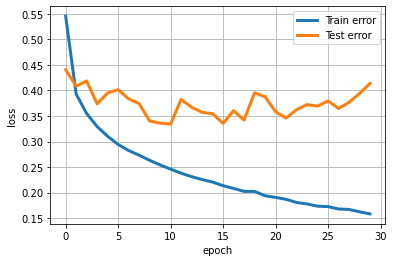

In [6]:
plt.plot(np.arange(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(np.arange(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [7]:
def evaluate(dataloader):
  total, correct = 0, 0
  net.eval() # don't update weights
  for data in dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    predicted_output = net(images)
    _, predicted_labels = torch.max(predicted_output,1)
    total += labels.size(0)
    correct += (predicted_labels == labels).sum().item()
  return 100 * correct/total

print('Train acc = %0.2f, test acc = %0.2f' % (evaluate(trainDataLoader), evaluate(testDataLoader)))


Train acc = 93.68, test acc = 88.88


Not bad! Could have been even more, if we had trained a bit longer.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


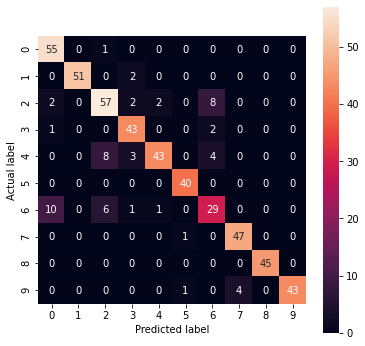

In [8]:
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=512, shuffle=False)
images, labels = iter(testDataLoader).next()
images = images.cuda()
labels = labels.cuda()
predicted_output = net(images)
_, predicted_labels = torch.max(predicted_output,1)

images = images.cpu()
labels = labels.cpu().numpy()
predicted_labels = predicted_labels.cpu().numpy()

from sklearn import metrics
conf_matrix = metrics.confusion_matrix(labels, predicted_labels)

import seaborn as sns
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, square = True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Looks good!